In [12]:
%%bash

# move over urls with a 0.7/0.3 split

if ! [ -f svms-data/url.train.svm ]; then
  cp urls-data/all00.svm svms-data/url.train.svm
fi

if ! [ -f svms-data/url.test.svm ]; then
  cp urls-data/all01.svm svms-data/url.test.svm
fi

In [ ]:
%%bash

# fetch all
# kdda kddb kdd12 x train test

# TODO: dead slow just replace with a sisu get-raw s3 after
# url is de-binarized (but do save the original fetch urls)
# s3://sisu-datasets/binary-svms/raw.tar.zst
exit 1

if ! [ -f svms-data/kdda.train.svm ]; then
  wget -q -O /tmp/kdda.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kdda.bz2 &
fi
if ! [ -f svms-data/kdda.test.svm ]; then
  wget -q -O /tmp/kdda.t.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kdda.t.bz2 &
fi
if ! [ -f svms-data/kddb.train.svm ]; then
  wget -q -O /tmp/kddb.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kddb.bz2 &
fi
if ! [ -f svms-data/kddb.test.svm ]; then
  wget -q -O /tmp/kddb.t.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kddb.t.bz2 &
fi
if ! [ -f svms-data/kdd12.train.svm ]; then
  wget -q -O /tmp/kdd12.tr.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kdd12.tr.bz2 &
fi
if ! [ -f svms-data/kdd12.test.svm ]; then
  wget -q -O /tmp/kdd12.val.bz2 \
    https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/kdd12.val.bz2 &
fi
wait

In [8]:
%%bash
# extract all 

if ! [ -f svms-data/kdda.train.svm ]; then
  (bzip2 -d /tmp/kdda.bz2 && mv /tmp/kdda svms-data/kdda.train.svm) &
fi
if ! [ -f svms-data/kdda.test.svm ]; then
  (bzip2 -d /tmp/kdda.t.bz2 && mv /tmp/kdda.t svms-data/kdda.test.svm) &
fi
if ! [ -f svms-data/kddb.train.svm ]; then
  (bzip2 -d /tmp/kddb.bz2 && mv /tmp/kddb svms-data/kddb.train.svm) &
fi
if ! [ -f svms-data/kddb.test.svm ]; then
  (bzip2 -d /tmp/kddb.t.bz2 && mv /tmp/kddb.t svms-data/kddb.test.svm) &
fi
if ! [ -f svms-data/kdd12.train.svm ]; then
  (bzip2 -d /tmp/kdd12.tr.bz2 && mv /tmp/kdd12.tr svms-data/kdd12.train.svm) &
fi
if ! [ -f svms-data/kdd12.test.svm ]; then
  (bzip2 -d /tmp/kdd12.val.bz2 && mv /tmp/kdd12.val svms-data/kdd12.test.svm) &
fi
wait

Process is interrupted.


In [11]:
%%bash

# vw install manually at this point
# https://github.com/VowpalWabbit/vowpal_wabbit/wiki/Dependencies

# check our datasets are "truly sparse" in that they have variable length
# unlike criteo

echo url kdda kddb kdd12 | xargs -n1 -I {} -P 4 bash -c '
stats=$(awk "{print NF}" svms-data/{}.train.svm | datamash min 1 median 1 mean 1 max 1)
printf "%10s nnz per row min %5.0f median %5.0f mean %5.0f max %5.0f\n" {} $stats
'

       url nnz per row min     0 median     0 mean     0 max     0
      kdda nnz per row min     0 median     0 mean     0 max     0
      kddb nnz per row min     0 median     0 mean     0 max     0
     kdd12 nnz per row min     0 median     0 mean     0 max     0


awk: fatal: cannot open file `svms-data/url.train.svm' for reading (No such file or directory)
awk: fatal: cannot open file `svms-data/kdda.train.svm' for reading (No such file or directory)
awk: fatal: cannot open file `svms-data/kddb.train.svm' for reading (No such file or directory)
awk: fatal: cannot open file `svms-data/kdd12.train.svm' for reading (No such file or directory)


In [6]:
%%bash

# below two cmds show that kdd12 has >7 dimensions, even
# though nnz == 7 for every row, it's not 7 categorical
# variables

awk '
{
  for (i = 2; i <= NF; ++i) {
    s = index($i, ":");
    $i = substr($i, 1, s - 1) + 0;
    counts[i, $i]++;
  }
}
END {
  k = 0;
  for (c in counts) k++;
  print k
}
' svms-data/kdd12.train.svm

awk: fatal: cannot open file `svms-data/kdd12.train.svm' for reading (No such file or directory)


In [7]:
%%bash

cat svms-data/kdd12.train.svm|cut -d" " -f2- | tr ' ' '\n' | cut -d":" -f1 | awk '!seen[$0]++'  | wc -l

0


cat: svms-data/kdd12.train.svm: No such file or directory


In [ ]:
%%bash

datasets="url kdda kddb kdd12"

budget=1024
for dataset in $datasets ; do
  echo "*************************" ${dataset} "**********************"
  RAYON_NUM_THREADS=92 ./csl/target/release/csl --budget $budget \
    --compress Identity --train ./svms-data/${dataset}.train.svm \
    --print-new-edges --valid ./svms-data/${dataset}.test.svm | \
    tee ./svms-data/bound-log.${dataset}.log
done

In [128]:
%%bash

scp "bigbox:~/spark-summit/sparksummit2020/svms-data/bound-log.*" ./svms-data

In [104]:
%%bash

datasets="url kdda kddb kdd12"

echo 'dataset & train ex. & test ex. & dense feat. & sparse feat. & avg. nnz& max nnz\\'
for dataset in $datasets ; do
  logfile="svms-data/bound-log.${dataset}.log"
  
  train="svms-data/${dataset}.train.svm"
  test="svms-data/${dataset}.test.svm"
  num_lines=$(cat $train | wc -l | awk -v "ORS=" '{print $NF/1000000}' | xargs -0 printf '%.2fM')
  test_num_lines=$(cat $test | wc -l | awk -v "ORS=" '{print $NF/1000000}' | xargs -0 printf '%.2fM')
  dense_features=$(grep "dense features" $logfile | awk '{print $NF}')
  sparse_features=$(grep "sparse features" $logfile | awk -v "ORS=" '{print $NF/1000000}' | xargs -0 printf '%.2fM')
  avg_nnz=$(grep "avg nnz" $logfile | awk '{print $NF}')
  max_nnz=$(grep "max nnz" $logfile | awk '{print $NF}')
  echo "\\texttt{$dataset} & $num_lines & $test_num_lines & $dense_features & $sparse_features & $avg_nnz & $max_nnz\\\\"

done

dataset & train ex. & test ex. & dense feat. & sparse feat. & avg. nnz& max nnz\\
\texttt{url} & 1.68M & 0.72M & 134 & 2.71M & 29 & 327\\
\texttt{kdda} & 8.41M & 0.51M & 0 & 19.31M & 36 & 85\\
\texttt{kddb} & 19.26M & 0.75M & 2 & 28.88M & 29 & 75\\
\texttt{kdd12} & 119.71M & 29.93M & 7 & 50.33M & 7 & 10\\


In [101]:
%%bash

datasets="url kdda kddb kdd12"

echo 'dataset & avg edges per ex. & $\card{V}$ & avg. degree & colors & CC \\' \
&& for dataset in $datasets ; do
  logfile="svms-data/bound-log.${dataset}.log"

  avg_edges_per_row=$(grep "avg edges per row" $logfile | awk '{print $NF}')
  sparse_features=$(grep "sparse features" $logfile | awk -v "ORS=" '{print $NF/1000000}' | xargs -0 printf '%.2fM')
  avg_degree=$(grep "avg degree" $logfile | grep -v "max degree" | head -1 | awk '{print $NF}')

  num_colors=$(grep "num colors" $logfile | awk -v "ORS=" '{print $NF}')
  color_collision_count=$(grep "color collision " $logfile | awk -v "ORS=" '{print $NF*100}' | xargs -0 printf '%.1f%%')

  echo "\\texttt{$dataset} & $avg_edges_per_row & $sparse_features & $avg_degree & $num_colors & $color_collision_count \\\\"
  
done

dataset & avg edges per ex. & $\card{V}$ & avg. degree & colors & CC \\
color collision count 0.4000005564528358
\texttt{url} & 481 & 2.71M & 74 & 395 & 40.0% \\
color collision count 0.3040905189476036
\texttt{kdda} & 682 & 19.31M & 129 & 103 & 30.4% \\
color collision count 0.21476855322213625
\texttt{kddb} & 439 & 28.88M & 130 & 79 & 21.5% \\
color collision count 0.09445102909984886
\texttt{kdd12} & 27 & 50.33M & 32 & 22 & 9.4% \\


In [129]:
%%bash

if true ; then
datasets="url kdda kddb kdd12"

function exarr {
prefix=${3:-thresholded }
key="${prefix}$1"
echo "\"$1\":" $(grep "^$key" "$2" | cut -c$(( 2 + ${#key}))-) ","
}

echo "{"
for dataset in $datasets ; do 

logfile="svms-data/bound-log.${dataset}.log"

echo "\"$dataset\": {"
exarr k $logfile
exarr "max degree" $logfile
exarr "avg degree" $logfile
exarr "Good-Turing estimate" $logfile
exarr "actual new edge avg" $logfile
#exarr "lines" $logfile "num "
echo "},"

done
echo "}"
# npm install -g relaxed-json
fi | rjson /dev/stdin > ./svms-data/parsed-log.json

In [130]:
maxnnz = {
'url': 327,
'kdda': 85,
'kddb': 75,
'kdd12': 10}
training = {
 'url': 1677291,
'kdda': 8407752,
'kddb': 19264097,
'kdd12': 119705032,   
}
concentration_term = {}
import math
for d in maxnnz:
    concentration_term[d] = maxnnz[d] ** 2 / math.sqrt(training[d]) * math.log(100)

In [131]:
import json
from itertools import chain
import pandas as pd
ds = json.load(open('./svms-data/parsed-log.json'))
df = pd.DataFrame.from_records(
    [dict(chain([('dataset', d)], zip(sorted(ds[d]), vs))) for d in ds for vs in zip(*(ds[d][k] for k in sorted(ds[d])))]
)
df.head()

,dataset,Good-Turing estimate,actual new edge avg,avg degree,k,max degree
0,url,30.902519,35.460679,74.095566,1,330686
1,url,63.244160,57.494863,35.809147,2,180761
2,url,77.974202,71.959565,15.774444,3,86901
3,url,86.698079,80.425856,9.691223,4,54313
4,url,91.785786,85.617466,6.989130,5,39840


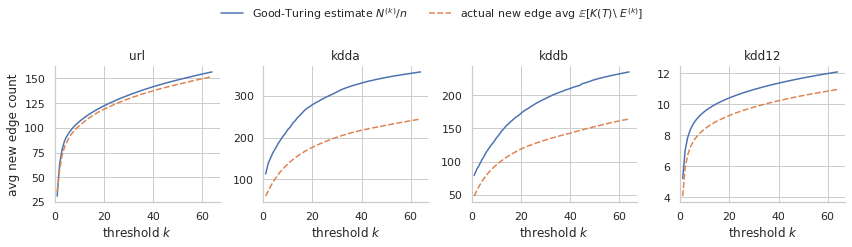

In [132]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ddf = df.copy()
ddf[r'threshold $k$'] = df.k
ddf['avg new edge count'] = df['Good-Turing estimate']
ddf['new edge type'] = r'Good-Turing estimate $N^{(k)}/n$'
ddf2 = ddf.copy()
ddf2['new edge type'] = r'actual new edge avg $\mathbb{E}[K(T)\backslash\ E^{(k)}]$'
ddf2['avg new edge count'] = df['actual new edge avg']
ddf.drop(columns=['actual new edge avg', 'Good-Turing estimate'], inplace=True)
ddf2.drop(columns=['actual new edge avg', 'Good-Turing estimate'], inplace=True)

ddf = pd.concat([ddf, ddf2])

g = sns.FacetGrid(ddf, col='dataset', hue='new edge type', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, r'threshold $k$', 'avg new edge count', style='new edge type',
                style_order=ddf['new edge type'].unique())

for ax in g.axes.flatten():
    t = ax.get_title()
    ax.set_title(t[len('dataset = '):])
    ax.set_xlim(0, None)
    
handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 4]
handles = [handles[ix] for ix in ixs]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)
plt.savefig('pics/gtworks.pdf',  bbox_inches='tight')

plt.show()

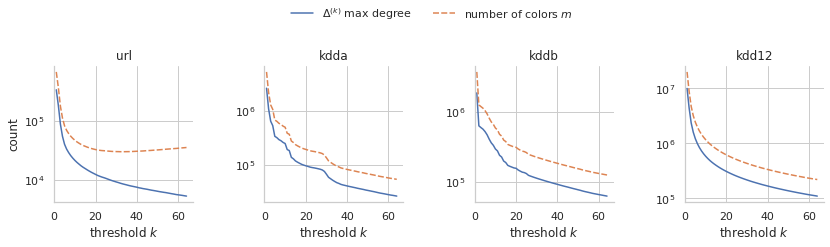

In [133]:
ddf = df.copy()
ddf[r'threshold $k$'] = df.k
ddf['count'] = df['max degree']
ddf['count type'] = r'$\Delta^{(k)}$ max degree'
ddf2 = ddf.copy()
ddf2['count'] = (
    df['max degree'] * 2 + 
    df['Good-Turing estimate'] +
    df.dataset.map(concentration_term) * df.k)
ddf2['count type'] = r'number of colors $m$'

ddf = pd.concat([ddf, ddf2])

g = sns.FacetGrid(ddf, col='dataset', hue='count type', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, r'threshold $k$', 'count', style='count type',
                style_order=ddf['count type'].unique())

for ax in g.axes.flatten():
    t = ax.get_title()
    ax.set_title(t[len('dataset = '):])
    ax.set_xlim(0, None)
    ax.set(yscale="log")

handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 4]
handles = [handles[ix] for ix in ixs]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)
plt.savefig('pics/maxdeghigh.pdf',  bbox_inches='tight')

plt.show()

In [145]:
%%bash

if true ; then
datasets="url kdda kddb kdd12"

function exarr {
key="filtered thresholded $1"
echo "\"$1\":" $(grep "^$key" "$2" | cut -c$(( 2 + ${#key}))-) ","
}

echo "{"
for dataset in $datasets ; do 

logfile="svms-data/bound-log.${dataset}.log"

echo "\"$dataset\": {"
exarr k $logfile
exarr "max degree" $logfile
exarr "avg degree" $logfile
exarr "Good-Turing estimate" $logfile
exarr "num discrete" $logfile
exarr "actual new edge avg" $logfile
echo "},"

done
echo "}"
# npm install -g relaxed-json
fi | rjson /dev/stdin > ./svms-data/parsed-log-filtered.json

In [181]:
ds = json.load(open('./svms-data/parsed-log-filtered.json'))
df = pd.DataFrame.from_records(
    [dict(chain([('dataset', d)], zip(sorted(ds[d]), vs))) for d in ds for vs in zip(*(ds[d][k] for k in sorted(ds[d])))]
)
df.head()

,dataset,Good-Turing estimate,actual new edge avg,avg degree,k,max degree,num discrete
0,url,6.979018,8.297731,44.001830,1,3873,4529
1,url,16.158286,15.476968,21.443845,2,2900,3314
2,url,23.525906,22.294657,9.503527,3,2238,2389
3,url,29.246613,27.275953,5.809494,4,1867,1939
4,url,33.225763,30.785016,4.178822,5,1674,1673


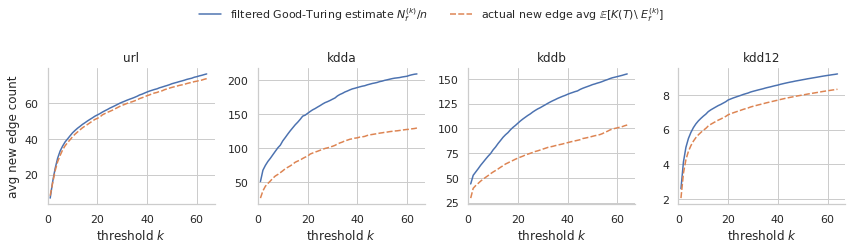

In [182]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

ddf = df.copy()
ddf[r'threshold $k$'] = df.k
ddf['avg new edge count'] = df['Good-Turing estimate']
ddf['new edge type'] = r'filtered Good-Turing estimate $N_f^{(k)}/n$'
ddf2 = ddf.copy()
ddf2['new edge type'] = r'actual new edge avg $\mathbb{E}[K(T)\backslash\ E_f^{(k)}]$'
ddf2['avg new edge count'] = df['actual new edge avg']
ddf.drop(columns=['actual new edge avg', 'Good-Turing estimate'], inplace=True)
ddf2.drop(columns=['actual new edge avg', 'Good-Turing estimate'], inplace=True)

ddf = pd.concat([ddf, ddf2])

g = sns.FacetGrid(ddf, col='dataset', hue='new edge type', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, r'threshold $k$', 'avg new edge count', style='new edge type',
                style_order=ddf['new edge type'].unique())

for ax in g.axes.flatten():
    t = ax.get_title()
    ax.set_title(t[len('dataset = '):])
    ax.set_xlim(0, None)
    
handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 4]
handles = [handles[ix] for ix in ixs]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)
plt.savefig('pics/gtfilter.pdf',  bbox_inches='tight')

plt.show()

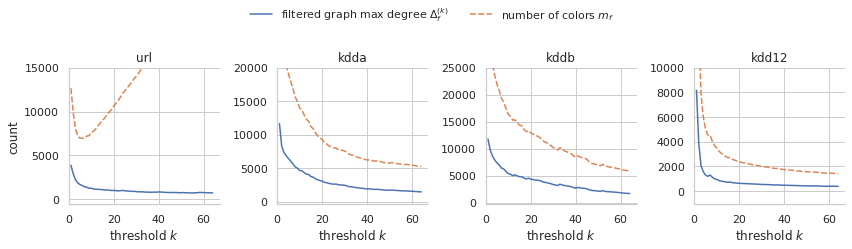

In [183]:
ddf = df.copy()
ddf[r'threshold $k$'] = df.k
ddf['count'] = df['max degree']
ddf['count type'] = r'filtered graph max degree $\Delta_f^{(k)}$'
ddf2 = ddf.copy()
ddf2['count'] = (
    df['max degree'] * 2 + 
    df['Good-Turing estimate'] +
    df.dataset.map(concentration_term) * df.k
    + df['num discrete'])
ddf2['count type'] = r'number of colors $m_f$'

ddf = pd.concat([ddf, ddf2])

g = sns.FacetGrid(ddf, col='dataset', hue='count type', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, r'threshold $k$', 'count', style='count type',
                style_order=ddf['count type'].unique())

ylims = [15000, 20000, 25000, 10000]
for ax, yl in zip(g.axes.flatten(), ylims):
    t = ax.get_title()
    ax.set_title(t[len('dataset = '):])
    ax.set_xlim(0, None)
    ax.set_ylim(None, yl)
    #ax.set(yscale='log')

handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 4]
handles = [handles[ix] for ix in ixs]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)
plt.savefig('pics/reducedcolors.pdf',  bbox_inches='tight')

plt.show()

In [187]:
ks = {'url': 5, 'kdda': 64, 'kddb': 64, 'kdd12': 64}
ksv = ' '.join(f"\"{d} {k}\"" for d, k in ks.items())
print(ksv)
ix = ddf2.dataset != ddf2.dataset
for d, k in ks.items():
    ix |= (ddf2.dataset == d) & (ddf2.k == k)
    
dgt = dict(zip(ddf2.loc[ix, 'dataset'], ddf2.loc[ix, 'Good-Turing estimate']))
dgt = dict(zip(ddf2.loc[ix, 'dataset'], ddf2.loc[ix, 'Good-Turing estimate']))
ws = dict(zip(ddf2.loc[ix, 'dataset'], ddf2.loc[ix, 'num discrete']))

"url 5" "kdda 64" "kddb 64" "kdd12 64"


In [ ]:
%%bash -s {ksv}

budget=1024
for dataset_k in "$@"; do
  dataset=$(echo $dataset_k | cut -d" " -f1)
  k=$(echo $dataset_k | cut -d" " -f2)
  echo "*************************" ${dataset} "**********************"
  RAYON_NUM_THREADS=92 ./csl/target/release/csl --budget $budget \
    --compress Identity --train ./svms-data/${dataset}.train.svm \
    --print-new-edges --valid ./svms-data/${dataset}.test.svm \
    --k $k --diagnostic-colors $(seq 1000 1000 10000) | \
    tee ./svms-data/colors.${dataset}.log
done

In [206]:
%%bash

scp "bigbox:~/spark-summit/sparksummit2020/svms-data/colors.*.log" ./svms-data/

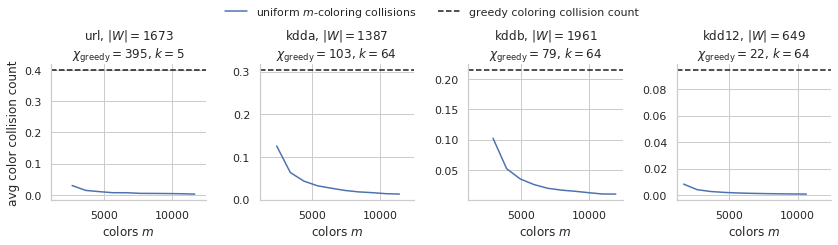

In [214]:
def extract(keyphrase, file):
    x = !! grep "{keyphrase}" "{file}"
    prefix = len(keyphrase) + 1
    return x[0][prefix:]

records = []
greedy = {}
for d in ['url', 'kdda', 'kddb', 'kdd12']: 
    logfile = f'./svms-data/colors.{d}.log'
    cc = eval(extract("glauber collisions", logfile))
    gc = eval(extract("greedy num colors", logfile))
    gcc = eval(extract("color collision count", logfile))
    for x, y in cc:
        records.append({
            'dataset': d,
            'colors $m$': x,
            'avg color collision count': y,
        })
    greedy[d] = {
        'gnc': gc,
        'gcc': gcc,
        'mf': dgt[d]
    }
    
df = pd.DataFrame.from_records(records)

g = sns.FacetGrid(df, col='dataset', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, r'colors $m$', 'avg color collision count')

#ylims = [15000, 20000, 25000, 10000]
for ax, yl in zip(g.axes.flatten(), ylims):
    t = ax.get_title()
    d = t[len('dataset = '):]
    ax.set_title(d + r', $\left|W\right|=' + str(ws[d]) + '$\n' +
                 '$\chi_{\mathrm{greedy}}=' + str(greedy[d]['gnc']) + '$' +
                ', $k=' + str(ks[d]) + '$')
    ax.lines[-1].set_label('uniform $m$-coloring collisions')
    ax.axhline(greedy[d]['gcc'], ls='--', c='k', label='greedy coloring collision count')
    #ax.axvline(, ls='-.', c='r', label='number of colors for greedy' )
    #ax.set(yscale='log')
    #ax.set_ylim(None, 1)

handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 1]
handles = [handles[ix] for ix in ixs]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=2, frameon=False)
plt.savefig('pics/cc_vs_colors.pdf',  bbox_inches='tight')

plt.show()


In [ ]:
%%bash

bash colorize.sh

In [ ]:
%%bash

bash vw_logspace_experiments.sh # saves to svms-data/vw-results.jsonl

In [225]:
%%bash

# on gpu machine
python ray_pytorch_experiments.py "s3://sisu-datasets/binary-svms/" svms-data/pytorch-results.jsonl

download: s3://sisu-datasets/binary-svms/url.tgz to svms-data/url.tgz 


In [ ]:
%%bash

bash field_aware_colorize.sh

In [ ]:
%%bash

python ray_pytorch_experiments.py "s3://sisu-datasets/binary-svms/" svms-data/fa-results.jsonl yes

In [76]:
%%bash

scp bigbox:~/spark-summit/sparksummit2020/svms-data/vw-results.jsonl ./svms-data/

In [1]:
import json
records = []
with open('svms-data/vw-results.jsonl', 'r') as f:
    for line in f:
        records.append(json.loads(line))
        
import pandas as pd

df = pd.DataFrame.from_records(records)
df.head()

,learner,split,budget,train_examples,test_examples,dataset,compress,train_sec,train_acc,test_acc,train_logloss,test_logloss
0,vw-linear,,4096,1677291,718839,url,ft,15.02,0.979379,0.979644,0.058827,0.057074
1,vw-linear,,1024,1677291,718839,url,ft,14.30,0.971241,0.971262,0.080973,0.077571
2,vw-linear,,16384,1677291,718839,url,ft,16.28,0.981994,0.982380,0.050075,0.049582
3,vw-linear,,4096,838413,718839,url,sm,14.60,0.985108,0.984137,0.041932,0.045763
4,vw-linear,,1024,1677291,718839,url,ht,17.76,0.970989,0.971013,0.084586,0.087689


In [2]:
df['algo'] = df.compress.map({
    'ht': 'HT', 'sm': 'CL','ft': 'FT'})

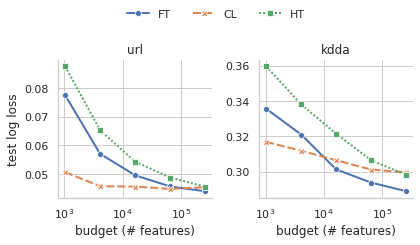

In [3]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", rc={"lines.linewidth": 2})

df['test log loss'] = df.test_logloss
df['budget (# features)'] = df.budget

g = sns.FacetGrid(df, col='dataset', hue='algo', sharey=False, legend_out=True, margin_titles=True)
g.map_dataframe(sns.lineplot, 'budget (# features)', 'test log loss', markers=True, style='algo', style_order=df.algo.unique())

for ax in g.axes.flatten():
    t = ax.get_title()
    ax.set_title(t[len('dataset = '):])
    
plt.gca().set_xscale('log')
handles, labels = plt.gca().get_legend_handles_labels()
ixs = [0, 5, 10]
handles = [handles[ix] for ix in ixs]
#ixs = [0, 1, 2]
labels = [labels[ix] for ix in ixs]
plt.gcf().legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.0), ncol=3, frameon=False)
plt.savefig('pics/lm.pdf',  bbox_inches='tight')

plt.show()

In [35]:
%%bash

scp p38:~/sparksummit2020/svms-data/pytorch-results.jsonl ./svms-data/

In [36]:
import json
records = []
with open('svms-data/pytorch-results.jsonl', 'r') as f:
    for line in f:
        records.append(json.loads(line))
        
import pandas as pd

df = pd.DataFrame.from_records(records)
df.head()

,train_epoch_logloss,test_acc,test_logloss,train_acc,train_logloss,train_examples,learner,budget,test_examples,train_sec,dataset,compress
0,"[0.24079337020286515, 0.05226138625359967, 0.0...",0.987067,0.036693,0.988971,0.030279,838413,wd,1024,718839,221.530483,url,sm
1,"[0.11158030143996278, 0.05499051550803957, 0.0...",0.983891,0.045564,0.981336,0.049005,1677291,wd,1024,718839,404.183271,url,ft
2,"[0.11158030143996278, 0.05499051550803957, 0.0...",0.983891,0.045564,0.981336,0.049005,1677291,wd,1024,718839,404.183271,url,ft
3,"[0.24079337020286515, 0.05226138625359967, 0.0...",0.987067,0.036693,0.988971,0.030279,838413,wd,1024,718839,221.530483,url,sm
4,"[0.4591780157294351, 0.3422884198282409, 0.321...",0.886207,0.295968,0.874145,0.315454,4203011,wd,1024,510302,1098.475605,kdda,sm


In [37]:
print(r'\begin{tabular}{llrrrr}')
print(r'\toprule')
datasets = ['url', 'kdda', 'kddb', 'kdd12']
ddatasets = [r'\texttt{' + d + '}' for d in datasets]
print(' & '.join(['learner', 'encoder'] + ddatasets) + r' \\')

for learner in df.learner.unique():
    print(r'\midrule')
    select = (df.learner == learner) & (df.budget == 1024)
    sub = df.loc[select, ['compress', 'dataset', 'test_logloss']]
    sub.drop_duplicates(['compress', 'dataset'], inplace=True)
    pivot = sub.pivot(index='compress', columns='dataset', values='test_logloss')
    maxs = pivot.min(axis=0)
    def format_float(row, d):
        f = row.get(d)
        if f is None:
            return 'nan'
        s = '{:.3f}'.format(f)
        if f == maxs.get(d):
            return r'\textbf{' + s + '}'
        return s
    for ix, row in pivot.iterrows():
        ix = 'CL+' + ix if ix.upper() in ['SM', 'TE'] else ix
        print('{} & {} & '.format(learner, ix).upper(), ' & '.join(
            format_float(row, d) for d in datasets),
             r'\\')
        learner = ''

print(r'\bottomrule')
print(r'\end{tabular}')

\begin{tabular}{llrrrr}
\toprule
learner & encoder & \texttt{url} & \texttt{kdda} & \texttt{kddb} & \texttt{kdd12} \\
\midrule
WD & FT &  0.046 & 0.326 & 0.314 & 0.172 \\
 & HT &  0.058 & 0.337 & 0.328 & 0.173 \\
 & CL+SM &  \textbf{0.037} & \textbf{0.296} & \textbf{0.276} & \textbf{0.159} \\
 & CL+TE &  0.325 & 0.588 & 0.517 & 0.280 \\
\midrule
LR & FT &  0.077 & 0.336 & 0.315 & 0.172 \\
 & HT &  0.087 & 0.359 & 0.330 & 0.175 \\
 & CL+SM &  \textbf{0.048} & \textbf{0.308} & \textbf{0.283} & \textbf{0.159} \\
 & CL+TE &  0.198 & 0.571 & 0.423 & 0.204 \\
\midrule
FM & FT &  0.076 & 0.321 & 0.311 & 0.172 \\
 & HT &  0.086 & 0.339 & 0.323 & 0.170 \\
 & CL+SM &  \textbf{0.063} & \textbf{0.303} & \textbf{0.282} & \textbf{0.159} \\
 & CL+TE &  0.253 & 0.691 & 0.665 & 0.206 \\
\midrule
NFM & FT &  0.045 & 0.320 & 0.309 & 0.172 \\
 & HT &  0.056 & 0.317 & 0.310 & 0.170 \\
 & CL+SM &  \textbf{0.040} & \textbf{0.291} & \textbf{0.271} & \textbf{0.158} \\
 & CL+TE &  0.285 & 0.804 & 0.839 & 0.294 

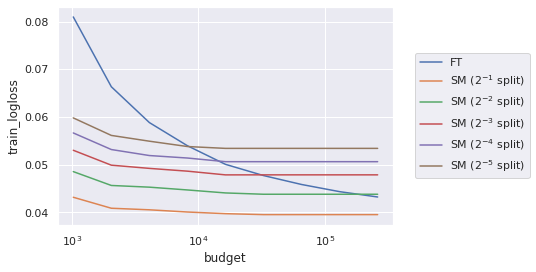

In [31]:
# didn't make it into paper, but really interesting to investigate other splits

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")


df['algo'] = df.compress.map({'ft': 'FT', 'sm': 'SM'})

s = df.split.apply(lambda s: '' if not s else r' ($2^{-' + str(s) + '}$ split)')
df.algo += s

df['test log loss'] = df.test_logloss

g = sns.lineplot(data=df, x='budget', y='train_logloss', hue='algo')

plt.gca().set_xscale('log')

handles, labels = g.get_legend_handles_labels()
g.legend(handles[1:], labels[1:], loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.savefig('pics/splits.pdf',  bbox_inches='tight')

plt.show()

# old xgb experiments below

In [108]:
%%bash

for bits in "" 8 ; do
for dataset in url kdda kddb kdd12  ; do
quiet="yes"
echo $dataset "$quiet" $bits
done
done | xargs -P 64 -L1 /bin/bash xgb.sh | tee svms-data/xgb_results.jsonl

{"objective":"binary:logistic","nthread":1,"load":59.34968662261963,"train":40.05630588531494,"num_round":10,"acc":0.9833258907766551,"auc":0.9973213586158615}
{"objective":"binary:logistic","nthread":1,"load":91.94347786903381,"train":150.99193739891052,"num_round":10,"acc":0.8797476788254798,"auc":0.7942308058315518}
{"objective":"binary:logistic","nthread":1,"load":130.60532879829407,"train":190.79666566848755,"num_round":10,"acc":0.9760001891939641,"auc":0.9959591910420694}
{"objective":"binary:logistic","nthread":1,"load":173.13418698310852,"train":289.0639805793762,"num_round":10,"acc":0.8899159675093967,"auc":0.8050354686260749}
{"objective":"binary:logistic","nthread":1,"load":201.37529683113098,"train":1213.0686185359955,"num_round":10,"acc":0.8783171533719248,"auc":0.6810216410049085}
{"objective":"binary:logistic","nthread":1,"load":460.77530121803284,"train":959.2170100212097,"num_round":10,"acc":0.9554960997121908,"auc":0.7339859718924813}
{"objective":"binary:logistic","n

In [91]:
x = !! wc -l svms-data/{url,kdda,kddb,kdd12}.train.svm
print('\n'.join(x))

    1677291 svms-data/url.train.svm
    8407752 svms-data/kdda.train.svm
   19264097 svms-data/kddb.train.svm
  119705032 svms-data/kdd12.train.svm
  149054172 total


In [98]:
prefix2nex = {}
for xx in x:
    if xx.endswith('.train.svm'):
        *_, lines, filename = xx.split(' ')
        stop = len(filename) - len(".train.svm")
        start = len('svms-data/')
        prefix2nex[filename[start:stop]] = int(lines)
        

prefix2nex

{'url': 1677291, 'kdda': 8407752, 'kddb': 19264097, 'kdd12': 119705032}

In [119]:
import glob
import re

records = []

for fn in glob.glob('svms-data/*.model.json'):
    with open(fn, 'r') as f:
        record = json.load(f)
        record['cl'] = 'bits_' not in fn
        for k, v in prefix2nex.items():
            if k in fn:
                record['nex'] = v
                record['dataset'] = k
        if record['cl']:
            record['bits'] = int(re.search(r'/bits(\d+)_', fn).group(1))
            if record['bits'] != 8:
                continue
            x = !! grep "e2e pipeline time" svms-data/{record['dataset']}.sm256.log
            assert len(x) == 1
            record['prep_time'] = int(x[0].split(' ')[-1][:-1])
        
    records.append(record)
    
df = pd.DataFrame.from_records(records)

df['prep_time + train'] = df.prep_time.fillna(0) + df.train

df[['cl', 'prep_time', 'train', 'dataset', 'auc', 'prep_time + train']].sort_values(['dataset', 'cl'])

,cl,prep_time,train,dataset,auc,prep_time + train
7,False,NaN,6070.103723,kdd12,0.667532,6070.103723
1,True,355.0,959.217010,kdd12,0.733986,1314.217010
6,False,NaN,1213.068619,kdda,0.681022,1213.068619
2,True,201.0,150.991937,kdda,0.794231,351.991937
4,False,NaN,2290.913014,kddb,0.677056,2290.913014
5,True,357.0,289.063981,kddb,0.805035,646.063981
0,False,NaN,190.796666,url,0.995959,190.796666
3,True,25.0,40.056306,url,0.997321,65.056306


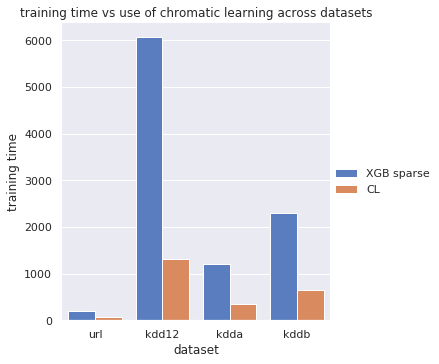

In [125]:
df["clname"] = df.cl.map({True: 'CL', False: 'XGB sparse'})
g = sns.catplot(x="dataset", y='prep_time + train', hue="clname", data=df,
                kind="bar", palette="muted", legend_out = True)
g._legend.set_title(None)
g.despine(left=True)
g.set_ylabels("training time")
plt.title('training time vs use of chromatic learning across datasets')
plt.show()

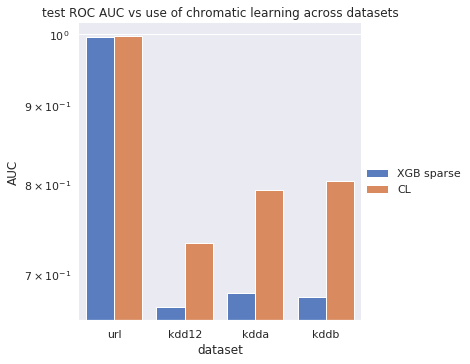

In [129]:
g = sns.catplot(x="dataset", y='auc', hue="clname", data=df,
                kind="bar", palette="muted", legend_out = True)
g._legend.set_title(None)
g.despine(left=True)
g.set_ylabels("AUC")
plt.title('test ROC AUC vs use of chromatic learning across datasets')
plt.gca().set(yscale="log")
plt.show()